# **Notebook 6 : Test du Modèle avec des Images Personnalisées**

Dans ce notebook, nous testons le modèle fusionné sur des images personnalisées pour observer ses prédictions. Les étapes clés sont :

- **Chargement du Modèle Fusionné :** Nous chargeons le modèle fusionné entraîné.
- **Préparation des Images de Test :** Nous sélectionnons des images personnalisées et les prétraitons (redimensionnement, normalisation).
- **Préparation des Légendes Associées :** Nous fournissons des légendes (éventuellement vides) pour accompagner les images.
- **Prédiction avec le Modèle Fusionné :** Nous utilisons le modèle pour prédire les classes associées aux images et aux légendes.
- **Affichage des Résultats :**
  - Nous affichons les classes prédites avec leurs probabilités.
  - Nous traçons un graphique des probabilités des classes prédites.
  - Nous affichons l'image avec les classes prédites en titre.

**Pourquoi ?**

Tester le modèle sur des images personnalisées nous permet de vérifier son fonctionnement en pratique et d'observer sa capacité à généraliser au-delà du jeu de données d'entraînement. C'est également une étape importante pour démontrer l'applicabilité du modèle dans des situations réelles.


In [81]:
# Import des bibliothèques nécessaires
import os
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
import re   

In [82]:

# Chemins des données et du modèle
data_dir = "../datasets/flickr8k/"
model_dir = "../models/"

# Charger le tokenizer et les labels de classe
with open(os.path.join(data_dir, "tokenizer.pkl"), "rb") as f:
    tokenizer = pickle.load(f)

with open(os.path.join(data_dir, "class_labels.pkl"), "rb") as f:
    class_labels = pickle.load(f)

# Charger le modèle fusionné
multi_modal_model = load_model(os.path.join(model_dir, "multi_modal_model.keras"))

print("Modèle fusionné chargé avec succès.")

Modèle fusionné chargé avec succès.


In [83]:

# Chemins vers les images de test
test_image_paths = ["../dog.png", "../happy-kid.jpg"]

# Paramètres globaux
IMG_SIZE = (224, 224)
MAX_SEQUENCE_LENGTH = 30  # Doit correspondre à la longueur utilisée précédemment

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img = img_to_array(img)
    img = preprocess_input(img)
    return img



In [84]:
# Fonction pour nettoyer et tokenizer la légende
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-z0-9 ]", "", caption)
    return caption

# Légende fictive, pour tester le modèle
test_caption = ""

# Nettoyer et tokenizer la légende
cleaned_caption = clean_caption(test_caption)
caption_sequence = tokenizer.texts_to_sequences([cleaned_caption])

# Padding de la séquence
test_sequence = pad_sequences(caption_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print("Légende de test préparée.")

Légende de test préparée.


Image de test '../dog.png' préparée.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prédiction terminée.
Top 12 classes prédites pour l'image '../dog.png':
a: 0.9996
the: 0.9954
is: 0.9874
in: 0.9653
dog: 0.9614
and: 0.9321
grass: 0.9179
black: 0.8066
white: 0.6611
brown: 0.6328
with: 0.5752
small: 0.5297


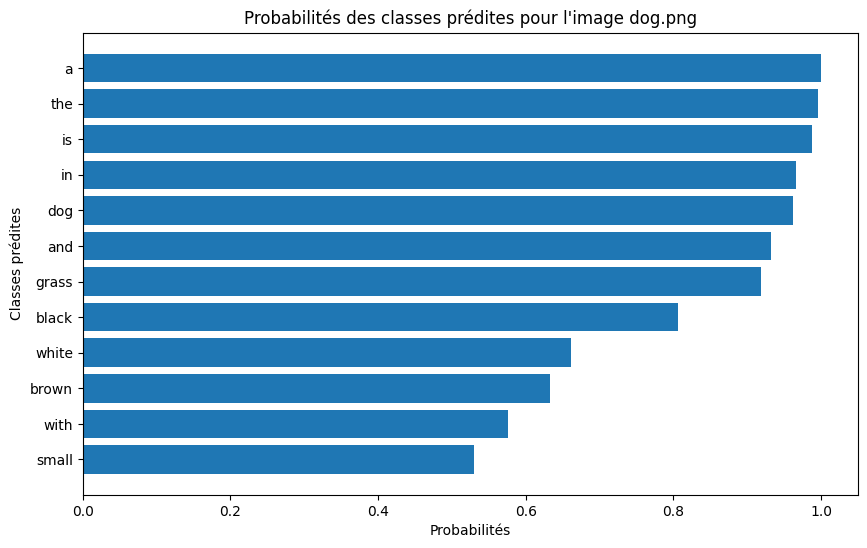

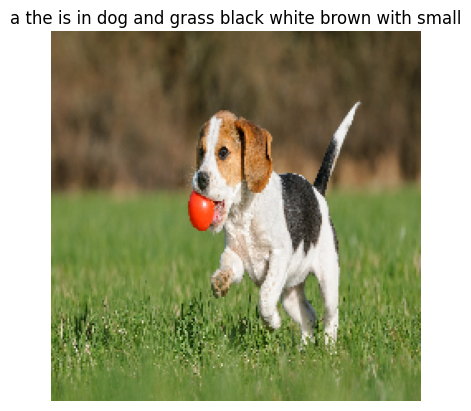

Image de test '../happy-kid.jpg' préparée.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prédiction terminée.
Top 12 classes prédites pour l'image '../happy-kid.jpg':
a: 0.9994
boy: 0.9857
in: 0.9811
is: 0.9726
the: 0.8858
child: 0.8447
his: 0.7735
little: 0.7107
blue: 0.6963
of: 0.6601
shirt: 0.6317
and: 0.6104


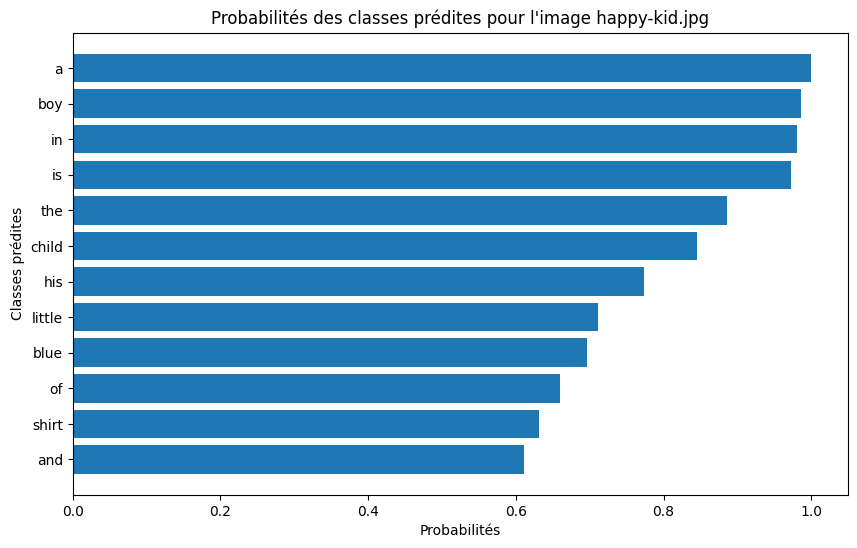

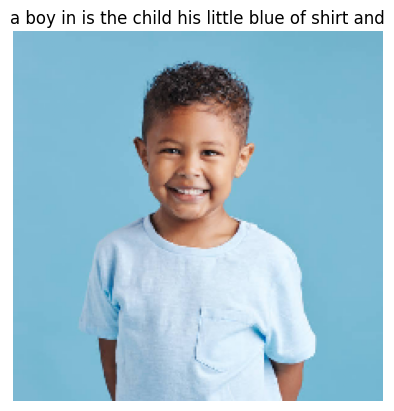

In [85]:

# Boucle sur les images de test
for test_image_path in test_image_paths:
    # Charger et prétraiter l'image
    test_image = load_and_preprocess_image(test_image_path)

    # Ajouter une dimension pour correspondre à la forme attendue par le modèle
    test_image_expanded = np.expand_dims(test_image, axis=0)

    print(f"Image de test '{test_image_path}' préparée.")

    # Faire une prédiction avec le modèle fusionné
    pred_prob = multi_modal_model.predict([test_image_expanded, test_sequence])

    # Obtenir les probabilités pour toutes les classes
    pred_prob = pred_prob[0]  # Extraire les probabilités de la première (et unique) prédiction

    # Obtenir les indices des classes triées par probabilité décroissante
    top_n = 12  # Nombre de classes à afficher
    sorted_indices = np.argsort(pred_prob)[::-1][:top_n]
    sorted_probabilities = pred_prob[sorted_indices]
    sorted_predicted_classes = [class_labels[i] for i in sorted_indices]

    # Afficher les classes prédites avec leurs probabilités
    print("Prédiction terminée.")
    print(f"Top {top_n} classes prédites pour l'image '{test_image_path}':")
    for cls, prob in zip(sorted_predicted_classes, sorted_probabilities):
        print(f"{cls}: {prob:.4f}")

    # Tracer un graphique des classes prédites en termes de probabilités
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_predicted_classes[::-1], sorted_probabilities[::-1])  # Inverser pour avoir la plus grande en haut
    plt.xlabel('Probabilités')
    plt.ylabel('Classes prédites')
    plt.title(f'Probabilités des classes prédites pour l\'image {os.path.basename(test_image_path)}')
    plt.show()

    # Afficher l'image
    img_display = (test_image + 1) / 2  # Inverser le prétraitement
    img_display = np.clip(img_display, 0, 1)  # S'assurer que les valeurs sont dans [0,1]
    plt.imshow(img_display)
    plt.axis('off')

    # Ajouter la légende prédite comme titre
    predicted_caption = " ".join(sorted_predicted_classes)
    plt.title(predicted_caption, fontsize=12, color='black')
    plt.show()